# Inaugural Project

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

## Question 1


First we define the parameters entering our utility function and budget constrain function in order to solve the consumer maximization problem.

In [2]:
# Define parameters:
m = 1
v = 10
eps = 0.3
tau0 = 0.4
tau1 = 0.1
kappa = 0.4
w = 1

In [3]:
def u_func(c,l,v,eps):
    '''Define the function we want to maximize
    
    input: 
        Labor supply (l) 
        Consumption (c)
        Frisch elasticity of labor supply (eps)
        Disutility of labor (v)
    
    return:
        Utility (u)
            '''
    u = np.log(c)-v*(l**(1+1/eps)/(1+1/eps)) 
    return u

In [4]:
def constraint(l,m,w,tau0,tau1,kappa):
    '''Constraint on total ressources given by x
    
    input:
        Labor supply (l) 
        Wage rate (w)
        Standard labor income tax (tau0)
        Top bracket labor income tax (tau1) 
        Cash-on-hand (m)
        Cut-off (kappa)
    
    return:
        Total resources (x)

    '''
    
    x = m+w*l-(tau0*w*l+tau1*max(w*l-kappa,0))
    return x

To solve the consumer problem we use scipy's optimizer, which is a slightly more convinient and brief method than using loops in this matter. Further, we make sure to add bounds and the correct parameters.

In [5]:
# a. objective function
def find_best_choice(l,w,eps,v,tau0,tau1,kappa,m):
    ''' Defining the function we want maximized by using 
        the definition that c* must be equal to x '''

    c = constraint(l,m,w,tau0,tau1,kappa) # defining c* as equal to our constraint 
    return -u_func(c,l,v,eps) # return the negative value such that a minimize will yield a maximize

# b. call solver
def optimizer(w,eps,m,v,tau0,tau1,kappa):
    '''Function for optimization '''
    sol_case1 = optimize.minimize_scalar(find_best_choice,method='bounded',bounds=(0,1),args=(w,eps,v,tau0,tau1,kappa,m))

    # i. unpack solution
    l_star = sol_case1.x
    c_star = m+w*l_star-(tau0*w*l_star+tau1*max(w*l_star-kappa,0))
    u_star = u_func(c_star,l_star,v,eps)
    return [l_star,c_star,u_star] 

# c. function for printing the solution
def print_solution(l_star,c_star,u_star):
    print(f'l_star = {l_star:.4f}')
    print(f'c_star = {c_star:.4f}')
    print(f'u_star = {u_star:.4f}')

## Question 2

In [6]:
# We will plot l* and c* as functions of w
N = 10000
w_list = np.linspace(0.5,1.5,N) 
l_list = np.empty(N)
c_list = np.empty(N)
for i, w in enumerate(w_list):
    max_val = optimizer(w,eps,m,v,tau0,tau1,kappa)
    l_list[i] = max_val[0] 
    c_list[i] = max_val[1]

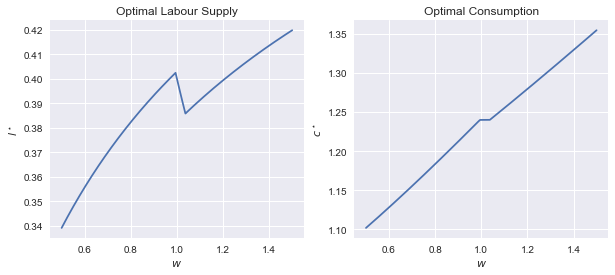

In [7]:
plt.style.use("seaborn")

# a. create the figure
fig = plt.figure(figsize=(10,4)) # figsize is in inches

# b. left plot: labor supply
ax_left = fig.add_subplot(1,2,1)

ax_left.plot(w_list,l_list)

ax_left.set_title('Optimal Labour Supply')
ax_left.set_xlabel('$w$')
ax_left.set_ylabel('$l^\star$')
ax_left.grid(True)

# c. right plot: Consumption
ax_right = fig.add_subplot(1,2,2)

ax_right.plot(w_list,c_list)

ax_right.set_title('Optimal Consumption')
ax_right.set_xlabel('$w$')
ax_right.set_ylabel('$c^\star$')
ax_right.grid(True)

When looking at the figure of optimal labour supply (to the left), we see a jump in labour supply for w=1. This is due to, the consumer faces an increase in marginal cost of consumption relative to leisure. At this point, the consumer will increase his demand for leisure with no changes in demand for consumption (as seen in the figure to the right). The consumer will increase his labour supply again, when the marginal utility of consumption equals the marginal utility of leisure. 

## Question 3

Now we wish to calculate the total tax revenue for our specified conditions in the problem. To do so we use the optimizer from question 2 and find the tax payment for individual i. To get the total tax revenue we sum up all of the payments. 

In [9]:
# a. setting seed, drawing wage from uniform distribution and generating tax payment specific for each individual 
np.random.seed(10)
wage = np.random.uniform(0.5,1.5,size=10000) # Wage for full population
Taxes_i= np.zeros(10000)
labor_i = np.empty(10000)

# b. Define function for tax for each individual
def TotalRevenue(wage,eps,tau0,tau1,kappa,v,m):
    for i, w in enumerate(wage):
        max_i = optimizer(w,eps,m,v,tau0,tau1,kappa)
        labor_i = max_i[0] # Generating a list of each individuals labor supply

        # Defining the function for tax revenue
        Taxes_i[i] = tau0*w*labor_i+tau1*max(w*labor_i-kappa,0)
    
    # i. Sum tax revenue for entire population
    TotalTax = sum(Taxes_i)
    return TotalTax

# Call the function for the total tax revenue and print result
TR = TotalRevenue(wage,eps,tau0,tau1,kappa,v,m)
print(f'The total tax revenue is {TR:.3f}')

The total tax revenue is 1613.685


## Question 4


We now examine what happens to the tax revenue if the Frisch-elasticity is instead 0.1

In [10]:
# # Call the function for the total tax revenue using a new value for epsilon
new_eps = 0.1
TR_new = TotalRevenue(wage,new_eps,tau0,tau1,kappa,v,m)
print(f'The tax revenue given the new value of elasticity is {TR_new:.3f}')

The tax revenue given the new value of elasticity is 3166.162


## Question 5

In [12]:
# a. create a vector containing the three variables we wish to optimize
taxes = np.zeros(3)
new_wage = np.random.uniform(0.5,1.5,size=10) # Wage for smaller population
# b. objective function
def find_best_taxes(taxes,new_wage,eps,v,m):
    tau0 = taxes[0]
    tau1 = taxes[1]
    kappa = taxes[2]
    return -TotalRevenue(new_wage,eps,m,v,tau0,tau1,kappa)

# c. define function to find the maximizing values of our vector, Taxes
def optimize_taxes(new_wage,eps,v,m):
    
    # i. call solver
    x0 = [0.8, 0.05, 0.5]
    sol_case2 = optimize.minimize(find_best_taxes,x0,method='Nelder-Mead',args=(new_wage,eps,v,m))

    # ii. unpack solution
    tau0_star = sol_case2.x[0]
    tau1_star = sol_case2.x[1]
    kappa_star = sol_case2.x[2]

    return [tau0_star,tau1_star,kappa_star]    

# d. print solution
[tau0_star,tau1_star,kappa_star]=optimize_taxes(wage,eps,v,m)
print(f'Optimal lower tax bound is {tau0_star:.4f}')
print(f'Optimal upper tax bound is {tau1_star:.4}')
print(f'Optimal cutoff is {kappa_star:.4f}')
TR_new = TotalRevenue(new_wage,eps,tau0_star,tau1_star,kappa_star,v,m)
print(f'The total tax revenue given the optimal taxes is {TR_new:.4f}')

KeyboardInterrupt: 

## Conclusion

Throughout this notebook we have maxmimized a labour supply problem and examined the optimal taxes from a politician view. 